In [1]:
# 本章节是一个关于文本的二分类问题
# 数据集是来自IMDB_dataset 包括了50000条电影评论被分为积极的和消极的两部分，样本是平衡状态的
import tensorflow as tf

D:\program_study\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow import keras
import numpy as np

imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [3]:
# 查看一下是否下载成功
train_data.shape

(25000,)

In [4]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [5]:
# 字典:用于将数字转向单词
word_index = imdb.get_word_index()

# key值不变，value值加3，并新增了4个键值对
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0 # 用来将每一个sentence扩充到同等长度
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # 未知，可能是生僻单词或是人名
word_index["UNUSED"] = 3

# 将键值对的键与值互换
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

# 转译为原句
def decode_review(text):
    return ' '.join([reverse_word_index.get(i,'?') for i in text])

In [6]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [7]:
# 有两种方式将整数数组送进神经网络
# 第一种：one-hot编码 将每一个sequence转译成num_words(10000)个 0s和 1s,代表每一个单词是否出现过，这种方式仅统计是否出现和不统计词频，
# 且是内存密集型的编码，总计会有num_words * num_reviews 大小的matrix
# 第二种：扩展整数数组让他们拥有相同的长度，这样每一个sequence会有共同的max_length（256），总计会占用 max_length*num_reviews大小
# 教程内采用第二种，在sequence后面扩充
train_data = keras.preprocessing.sequence.pad_sequences(train_data,value=word_index["<PAD>"],padding='post',maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,value=word_index["<PAD>"],padding='post',maxlen=256)

In [8]:
len(train_data[0]),len(train_data[10])

(256, 256)

In [9]:
# 构建模型
# 输入数据是单词组合，标签是0或者1
# 先进行数据稀疏稠密化，因为sequence里面的word_index值是[0~10000]内稀疏的，所以将每一个单词用一个16维的向量代替；input(1024,256)output(1024,256,16)
# 再通过均值的池化层，将每一个sequence做均值，类似于将单词合并 ;input(1024,256,16),output(1024,16)
# 全连接层采用relu激活函数;input(1024,16),output(1024,16)
# 全连接层采用sigmoid激活函数；input(1024,16),output(1024,1)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16,activation=tf.nn.relu))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 因为采用了sigmoid激活函数，所以损失函数不能用mse均方误差，因为在sigmoid函数的两端梯度很小，会使w和b更新很慢
# 所以采用交叉熵代价函数（cross-entropy cost function）
# 交叉熵代价函数具有非负性和当真实输出与期望输出相近的时候，代价函数接近于零
model.compile(optimizer=tf.train.AdamOptimizer(),loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
x_val =train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [12]:
history = model.fit(partial_x_train,partial_y_train,epochs=40,batch_size=1024,validation_data=(x_val,y_val),verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 71us/step - loss: 0.6920 - acc: 0.5508 - val_loss: 0.6906 - val_acc: 0.5857
Epoch 2/40
15000/15000 [==============================] - 1s 40us/step - loss: 0.6883 - acc: 0.6901 - val_loss: 0.6865 - val_acc: 0.7381
Epoch 3/40
15000/15000 [==============================] - 1s 39us/step - loss: 0.6829 - acc: 0.7601 - val_loss: 0.6804 - val_acc: 0.7343
Epoch 4/40
15000/15000 [==============================] - 1s 39us/step - loss: 0.6744 - acc: 0.7575 - val_loss: 0.6709 - val_acc: 0.7452
Epoch 5/40
15000/15000 [==============================] - 1s 40us/step - loss: 0.6627 - acc: 0.7718 - val_loss: 0.6592 - val_acc: 0.7601
Epoch 6/40
15000/15000 [==============================] - 1s 39us/step - loss: 0.6480 - acc: 0.7817 - val_loss: 0.6445 - val_acc: 0.7685
Epoch 7/40
15000/15000 [==============================] - 1s 40us/step - loss: 0.6301 - acc: 0.7905 - val_loss: 0.6272 - val_acc

In [13]:
# 测试集评估模型
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 1s 47us/step


In [14]:
results

[0.30940537487983705, 0.87352]

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

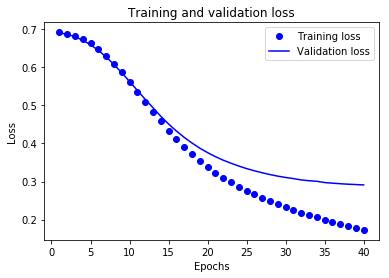

In [16]:
# 用matplot做一下显示
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

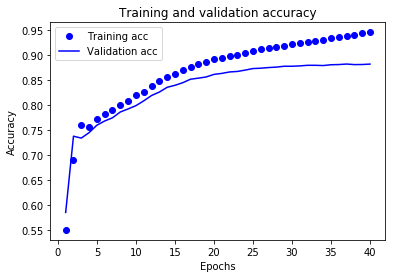

In [17]:
plt.clf()   # 清除图表
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()